# Package

In [ ]:
r <- getOption( "repos" );# set CRAN mirror for users in China
r[ "CRAN" ] <- "https://mirrors.tuna.tsinghua.edu.cn/CRAN/"; 
options(repos = r)

In [6]:
# Others
# install.packages('pacman')
# install.packages("prismatic")

# Cellchat
# install.packages("circlize")
# install.packages('NMF')
# devtools::install_github("immunogenomics/presto")
# BiocManager::install("ComplexHeatmap")
# install.packages("ggalluvial")
# install.packages("ggnetwork")
# install.packages("RSpectra")
# install.packages("clue")

# remotes::install_github("jinworks/CellChat")

In [50]:
my_packages <- c("data.table", "tidyverse",
                 "patchwork",
                 "GSEABase",
                 "CellChat",
                 "Seurat")
pacman::p_load(char = my_packages)

tmp <- list()

In [51]:
sessionInfo()
# BY mugpeng@foxmail.com

R version 4.3.0 (2023-04-21)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3 
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Asia/Shanghai
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] GSEABase_1.62.0      graph_1.78.0         annotate_1.78.0     
 [4] XML_3.99-0.14        AnnotationDbi_1.62.1 IRanges_2.34.0      
 [7] S4Vectors_0.38.1   

# Note

## Ref

- [jinworks/CellChat: R toolkit for inference, visualization and analysis of cell-cell communication from single-cell and spatially resolved transcriptomics](https://github.com/jinworks/CellChat)

## Fix

The image of P1T is labelled as P11T in the obj.

cellchat may encount error ref:
- [Question in analysis of Xenium or CosMx with CellChat · Issue #18 · jinworks/CellChat](https://github.com/jinworks/CellChat/issues/18)

# Preparation

In [4]:
getwd()

[1] "/data1/bioteam_usr/yzpeng/1-project/1212_XunYin"

In [1]:
spa_p1T <- readRDS(file = "Input/STData of HCC/P1T_Spatial.rds.gz")
spa_p9T <- readRDS(file = "Input/STData of HCC/P9T_Spatial.rds.gz")

In [2]:
spa_p1T

An object of class Seurat 
36635 features across 3348 samples within 4 assays 
Active assay: Spatial (36601 features, 2000 variable features)
 3 other assays present: Fibroblst_predictions, Endo_predictions, Myeloid_predictions
 3 dimensional reductions calculated: pca, tsne, umap
 6 images present: image_P11_N, image_P11_T, image_P12_N, image_P12_T, image_P15_N, image_P15_T

# Fig5A,B

Load the processed cellchat obj from our analysis:

In [40]:
cellchat_p1T <- readRDS(file = "tos_data/Data/fig5/p1T.Rds")
cellchat_p9T <- readRDS(file = "tos_data/Data/fig5/p9T.Rds")

## Preprocess

P1T

In [ ]:
meta = data.frame(labels = Idents(spa_p1T), slices = "slice1", row.names = names(Idents(spa_p1T))) # manually create a dataframe consisting of the cell labels
meta$slices <- factor(meta$slices)
spatial.locs = spa_p1T@images$image_P11_T@coordinates
spatial.locs = spatial.locs[,c(4:5)]
spot.size = 65 # the theoretical spot size (um) in 10X Visium
# spa_p1T@images$image_P11_T@image
conversion.factor = spot.size/spa_p1T@images$image_P11_T@scale.factors$fiducial
scale.factors = data.frame(ratio = conversion.factor, tol = spot.size/2)
cellchat_p1T <- createCellChat(object = spa_p1T, meta = meta, group.by = "labels",
                           datatype = "spatial", coordinates = spatial.locs, scale.factors = scale.factors)

CellChatDB <- CellChatDB.human
CellChatDB.use <- CellChatDB # simply use the
cellchat_p1T@DB <- CellChatDB.use

# subset the expression data of signaling genes for saving computation cost
cellchat_p1T <- subsetData(cellchat_p1T) # This step is necessary even if using the whole database
future::plan("multisession", workers = 4) 
cellchat_p1T <- identifyOverExpressedGenes(cellchat_p1T)
cellchat_p1T <- identifyOverExpressedInteractions(cellchat_p1T)

cellchat_p1T <- computeCommunProb(cellchat_p1T, type = "truncatedMean", trim = 0.1, 
                              distance.use = TRUE, interaction.range = 250, scale.distance = 0.02,
                              contact.knn = TRUE, contact.knn.k = 6)

# Filter out the cell-cell communication if there are only few number of cells in certain cell groups
cellchat_p1T <- filterCommunication(cellchat_p1T, min.cells = 10)

cellchat_p1T <- computeCommunProbPathway(cellchat_p1T)
cellchat_p1T <- aggregateNet(cellchat_p1T)

P9T

In [ ]:
meta = data.frame(labels = Idents(spa_p9T), slices = "slice1")# manually create a dataframe consisting of the cell labels
meta$labels <- plyr::mapvalues(
  as.character(meta$labels),
  from = c(
    levels(Idents(spa_p9T))
  ),
  to = c(
    c("Immune/fibroblast cells",
      "Malignant hepatocytes",
      "Hepatocytes",
      "Myeloid cells",
      "Fibro blast cells",
      "SPP1 +macrophages/ CAFs",
      "Cholangiocytes")
  )
)
meta$labels <- factor(meta$labels,
                      levels = c(
                        "Cholangiocytes",
                        "Fibro blast cells",
                        "Immune/fibroblast cells",
                        "Malignant hepatocytes",
                        "Hepatocytes",
                        "Myeloid cells",
                        "SPP1 +macrophages/ CAFs"
                      ))

meta$slices <- factor(meta$slices)
spatial.locs = spa_p9T@images$image@coordinates
spatial.locs = spatial.locs[,c(4:5)]
# Scale factors and spot diameters of the full resolution images 

spot.size = 65 # the theoretical spot size (um) in 10X Visium
# spa_p1T@images$image_P11_T@image
conversion.factor = spot.size/spa_p9T@images$image@scale.factors$fiducial
scale.factors = data.frame(ratio = conversion.factor, tol = spot.size/2)

cellchat_p9T <- createCellChat(object = spa_p9T, meta = meta, group.by = "labels",
                           datatype = "spatial", coordinates = spatial.locs, scale.factors = scale.factors)

CellChatDB <- CellChatDB.human # use 
CellChatDB.use <- CellChatDB # simply use the 
cellchat_p9T@DB <- CellChatDB.use

cellchat_p9T <- subsetData(cellchat_p9T) # This step is necessary even if using the whole database
future::plan("multisession", workers = 4) 
cellchat_p9T <- identifyOverExpressedGenes(cellchat_p9T)
cellchat_p9T <- identifyOverExpressedInteractions(cellchat_p9T)

cellchat_p9T <- computeCommunProb(cellchat_p9T, type = "truncatedMean", trim = 0.1, 
                              distance.use = TRUE, interaction.range = 250, scale.distance = 0.02,
                              contact.knn = TRUE, contact.knn.k = 6)

# Filter out the cell-cell communication if there are only few number of cells in certain cell groups
cellchat_p9T <- filterCommunication(cellchat_p9T, min.cells = 10)

cellchat_p9T <- computeCommunProbPathway(cellchat_p9T)
cellchat_p9T <- aggregateNet(cellchat_p9T)

## 5A

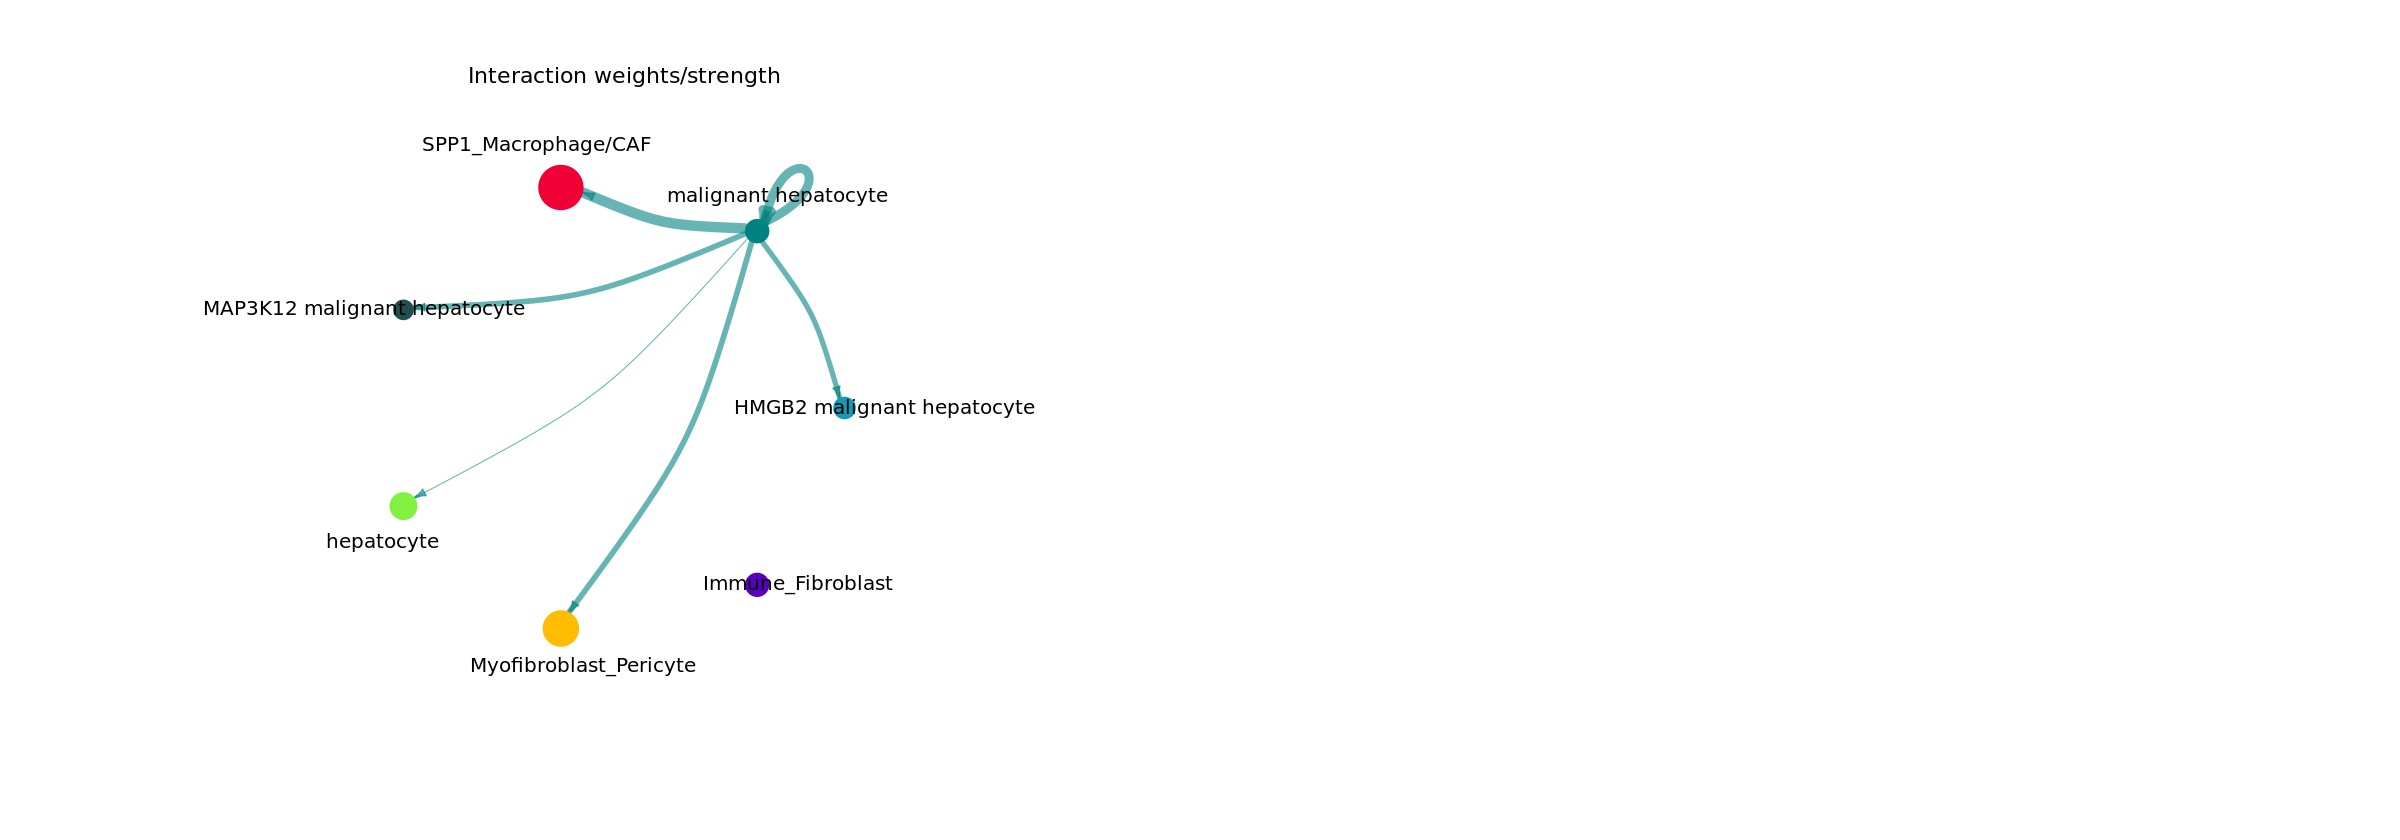

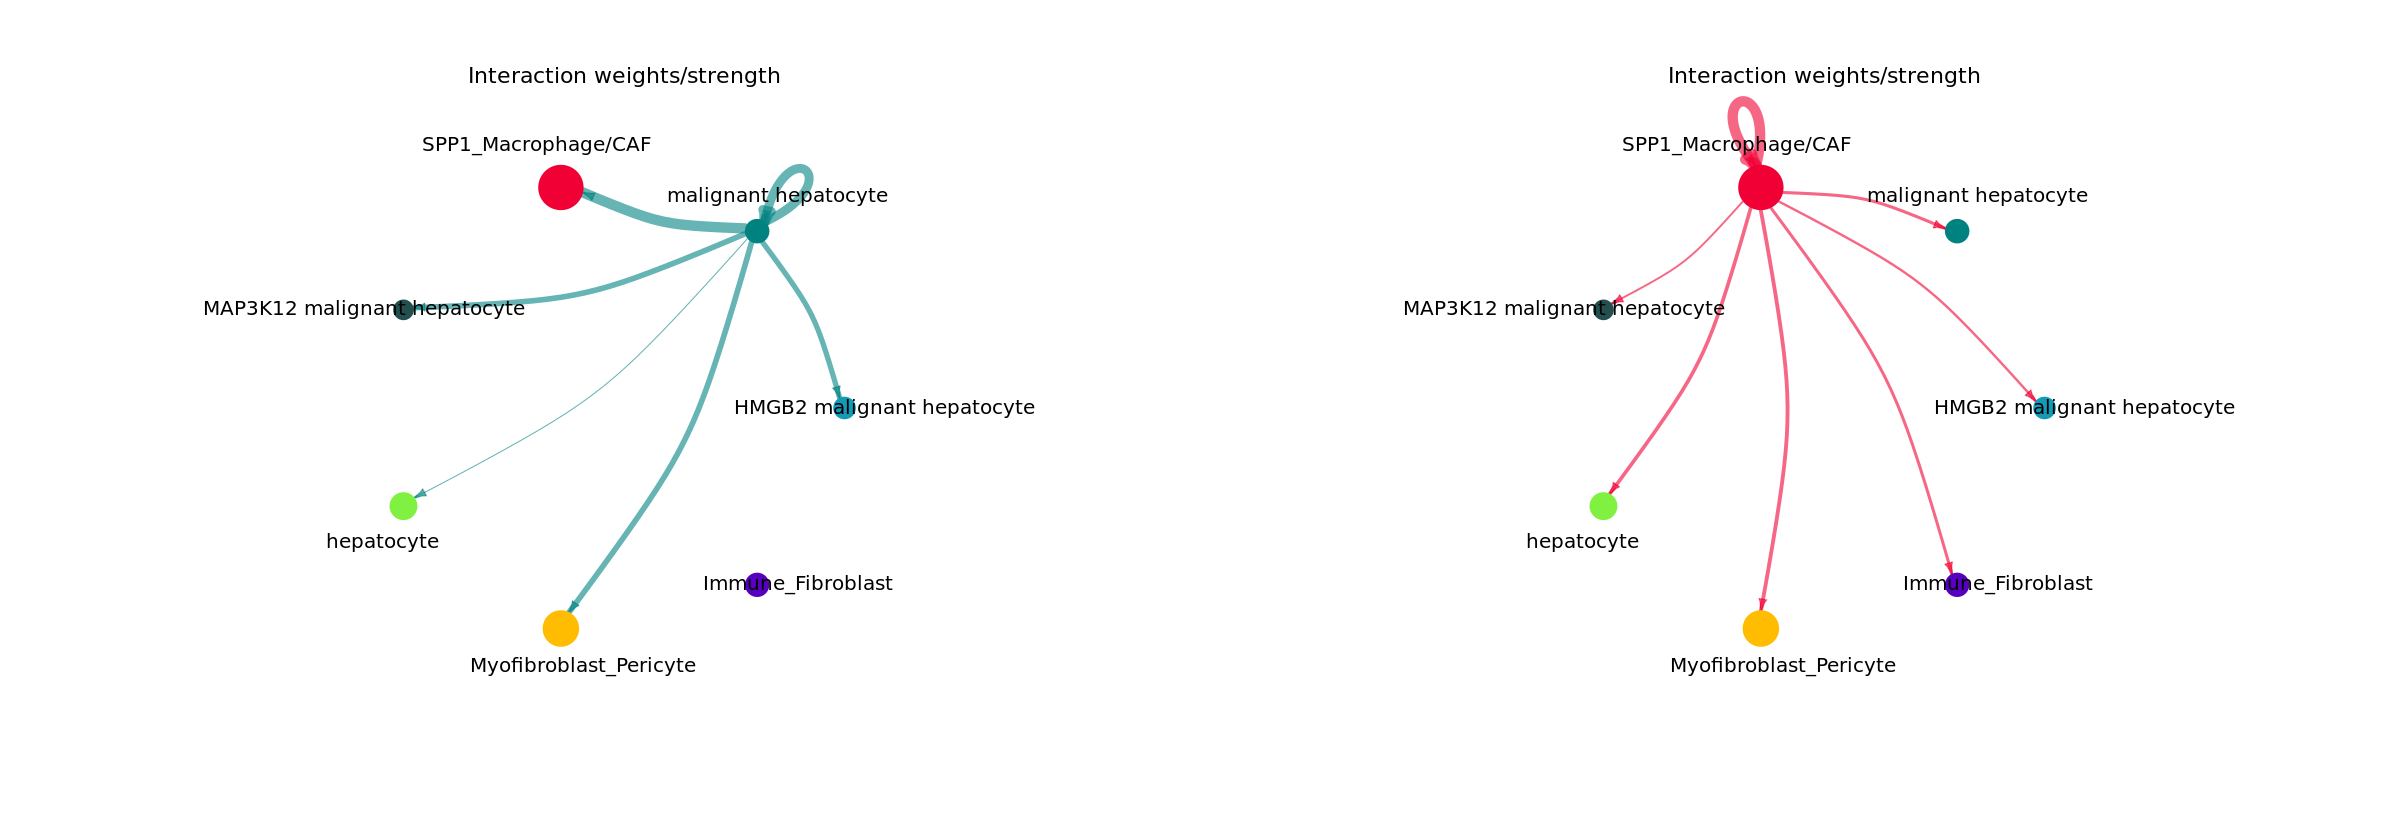

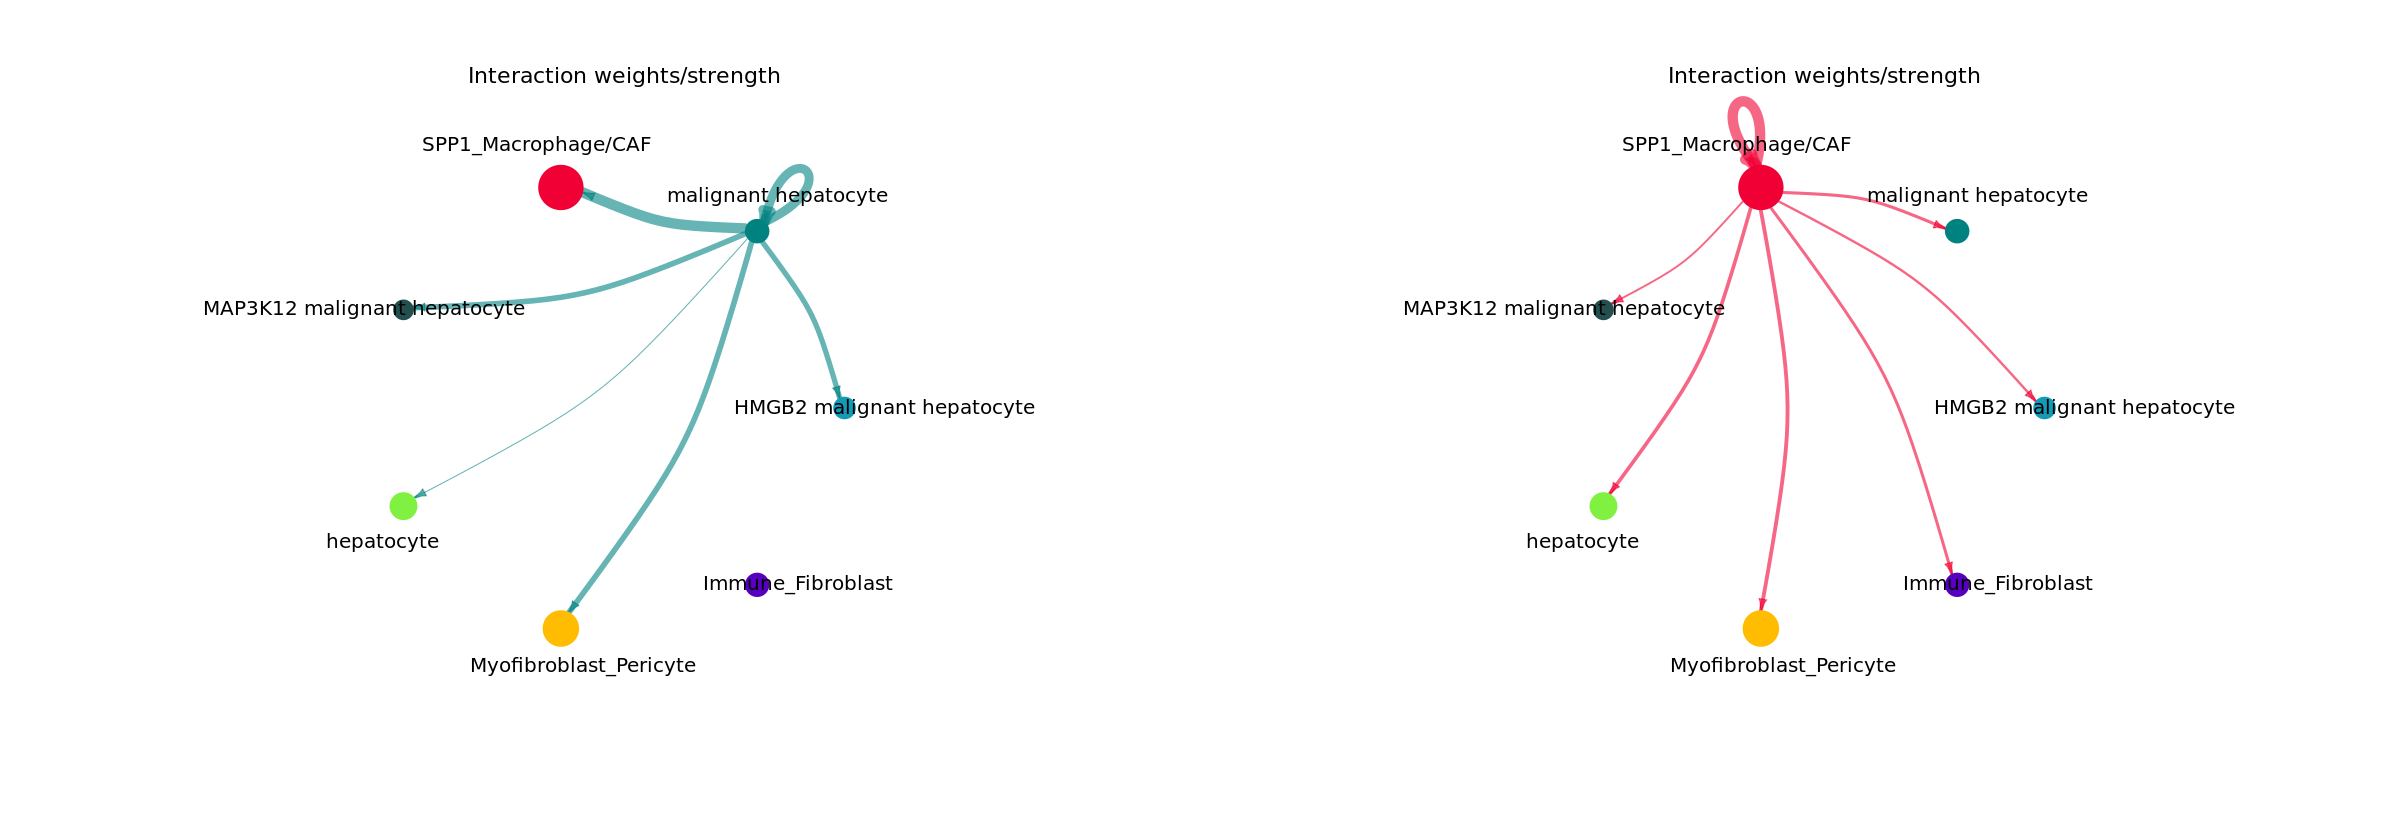

In [46]:
par(mfrow = c(1,2), xpd=T)
netVisual_circle(cellchat_p1T@net$weight, vertex.weight = rowSums(cellchat_p1T@net$weight), weight.scale = T, label.edge= F, title.name = "Interaction weights/strength", 
                 sources.use = "malignant hepatocyte", color.use = c("#139AB6FF",
                                                                     "#008281FF", 
                                                                     "#F00034FF", "#23504FFF", "#80F041FF",
                                                                     "#FFBC00FF", "#5800C0FF"))
netVisual_circle(cellchat_p1T@net$weight, vertex.weight = rowSums(cellchat_p1T@net$weight), weight.scale = T, label.edge= F, title.name = "Interaction weights/strength", 
                 sources.use = "SPP1_Macrophage/CAF", color.use = c("#139AB6FF",
                                                                     "#008281FF", 
                                                                     "#F00034FF", "#23504FFF", "#80F041FF",
                                                                     "#FFBC00FF", "#5800C0FF"))

## 5B

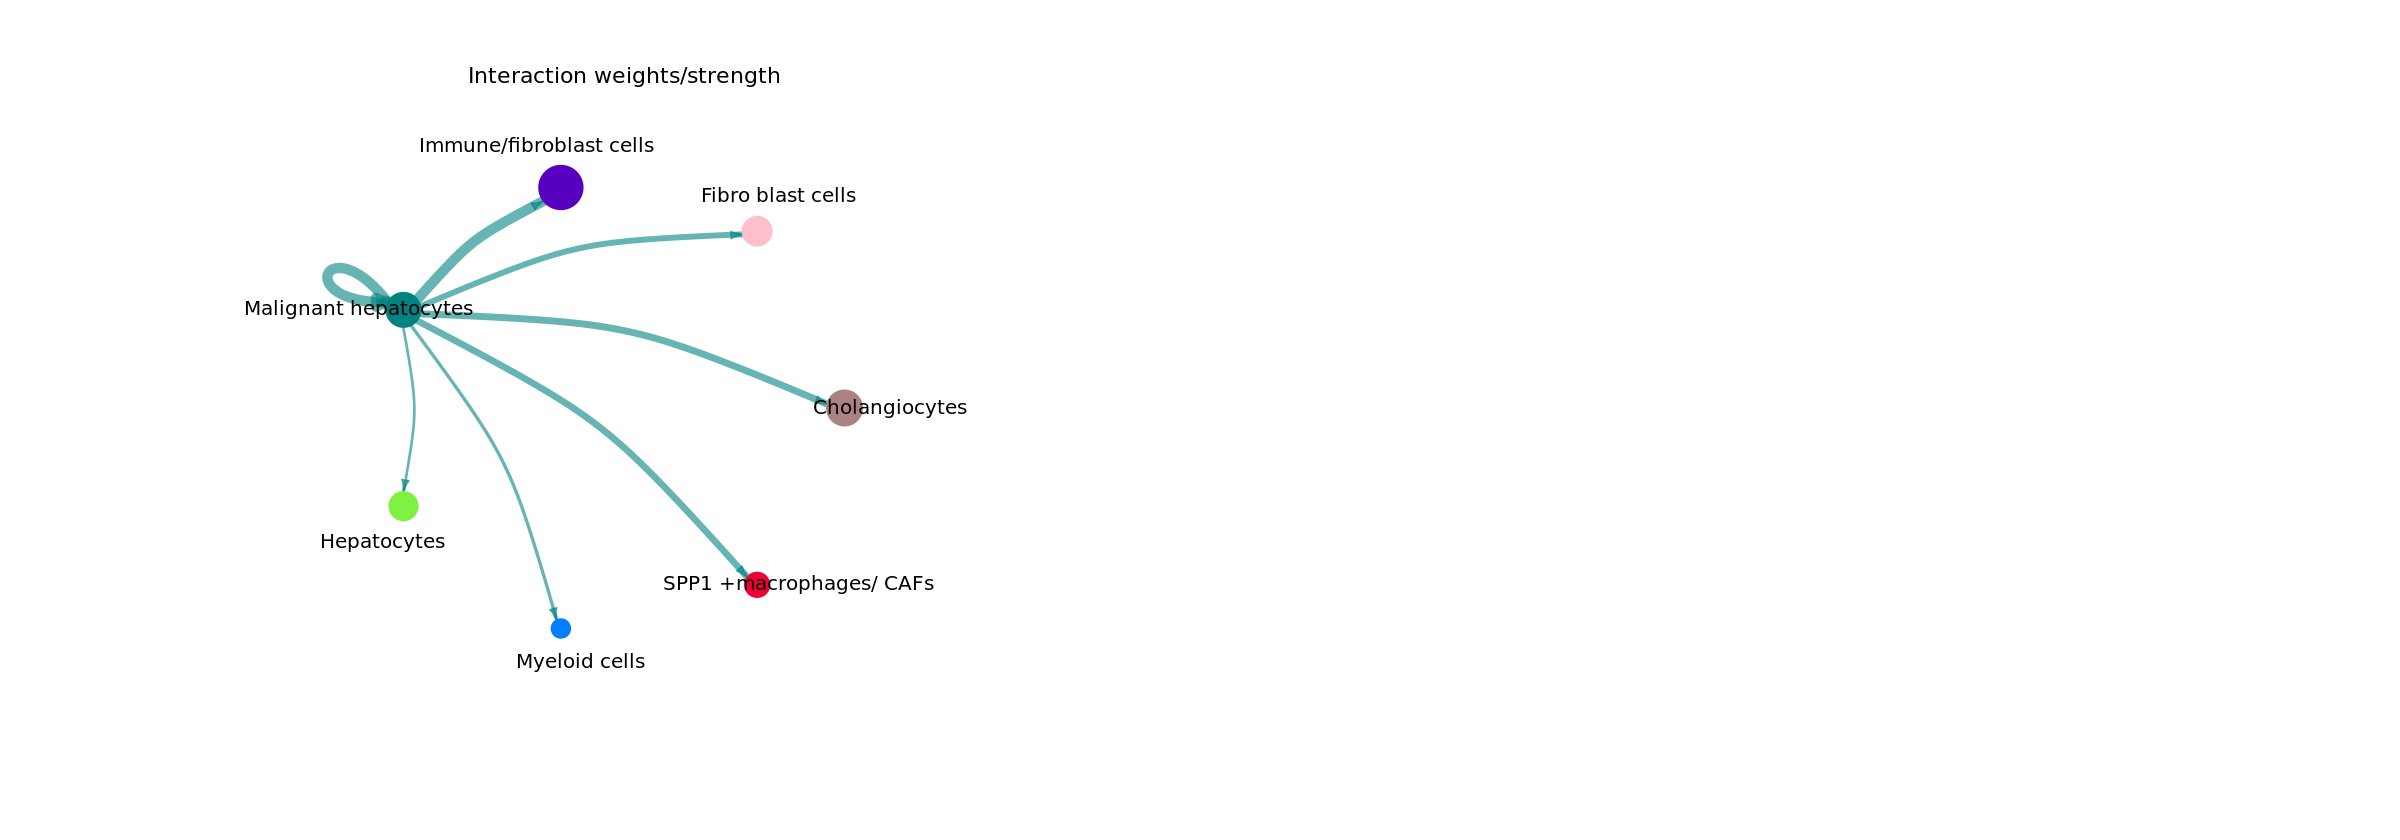

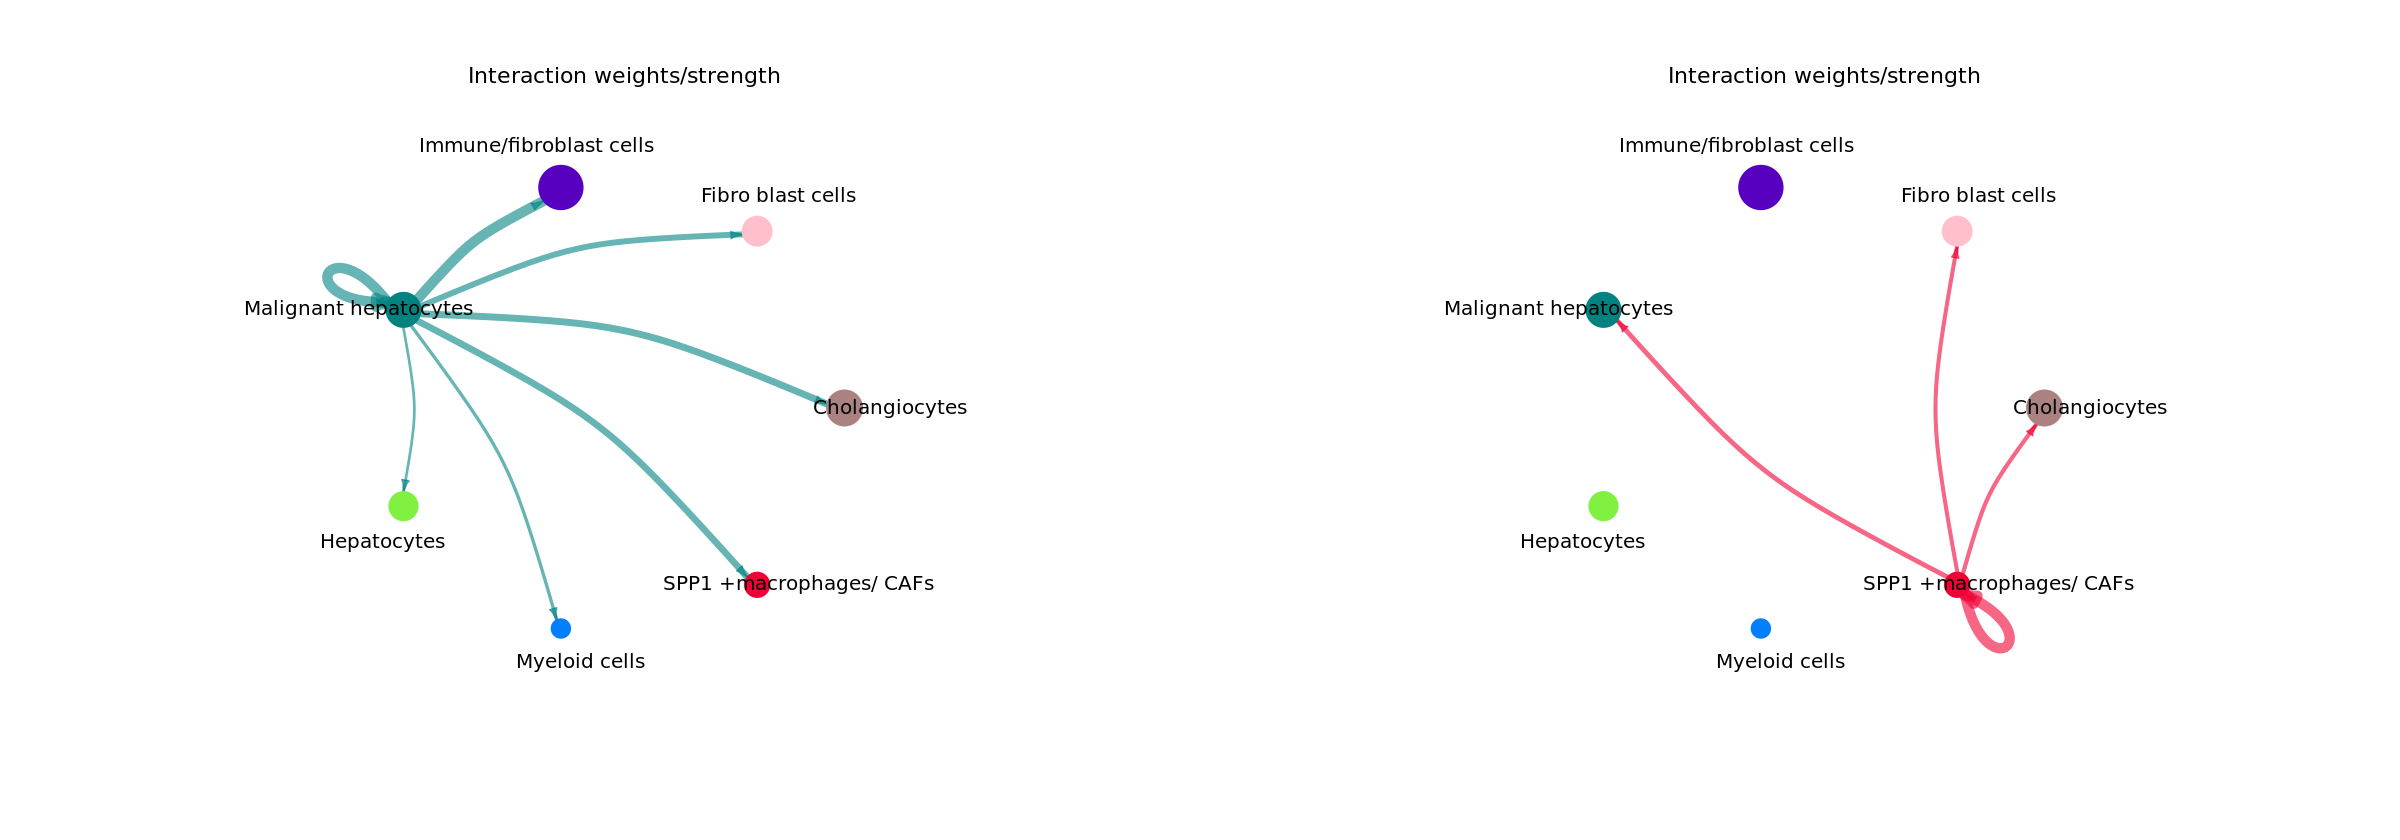

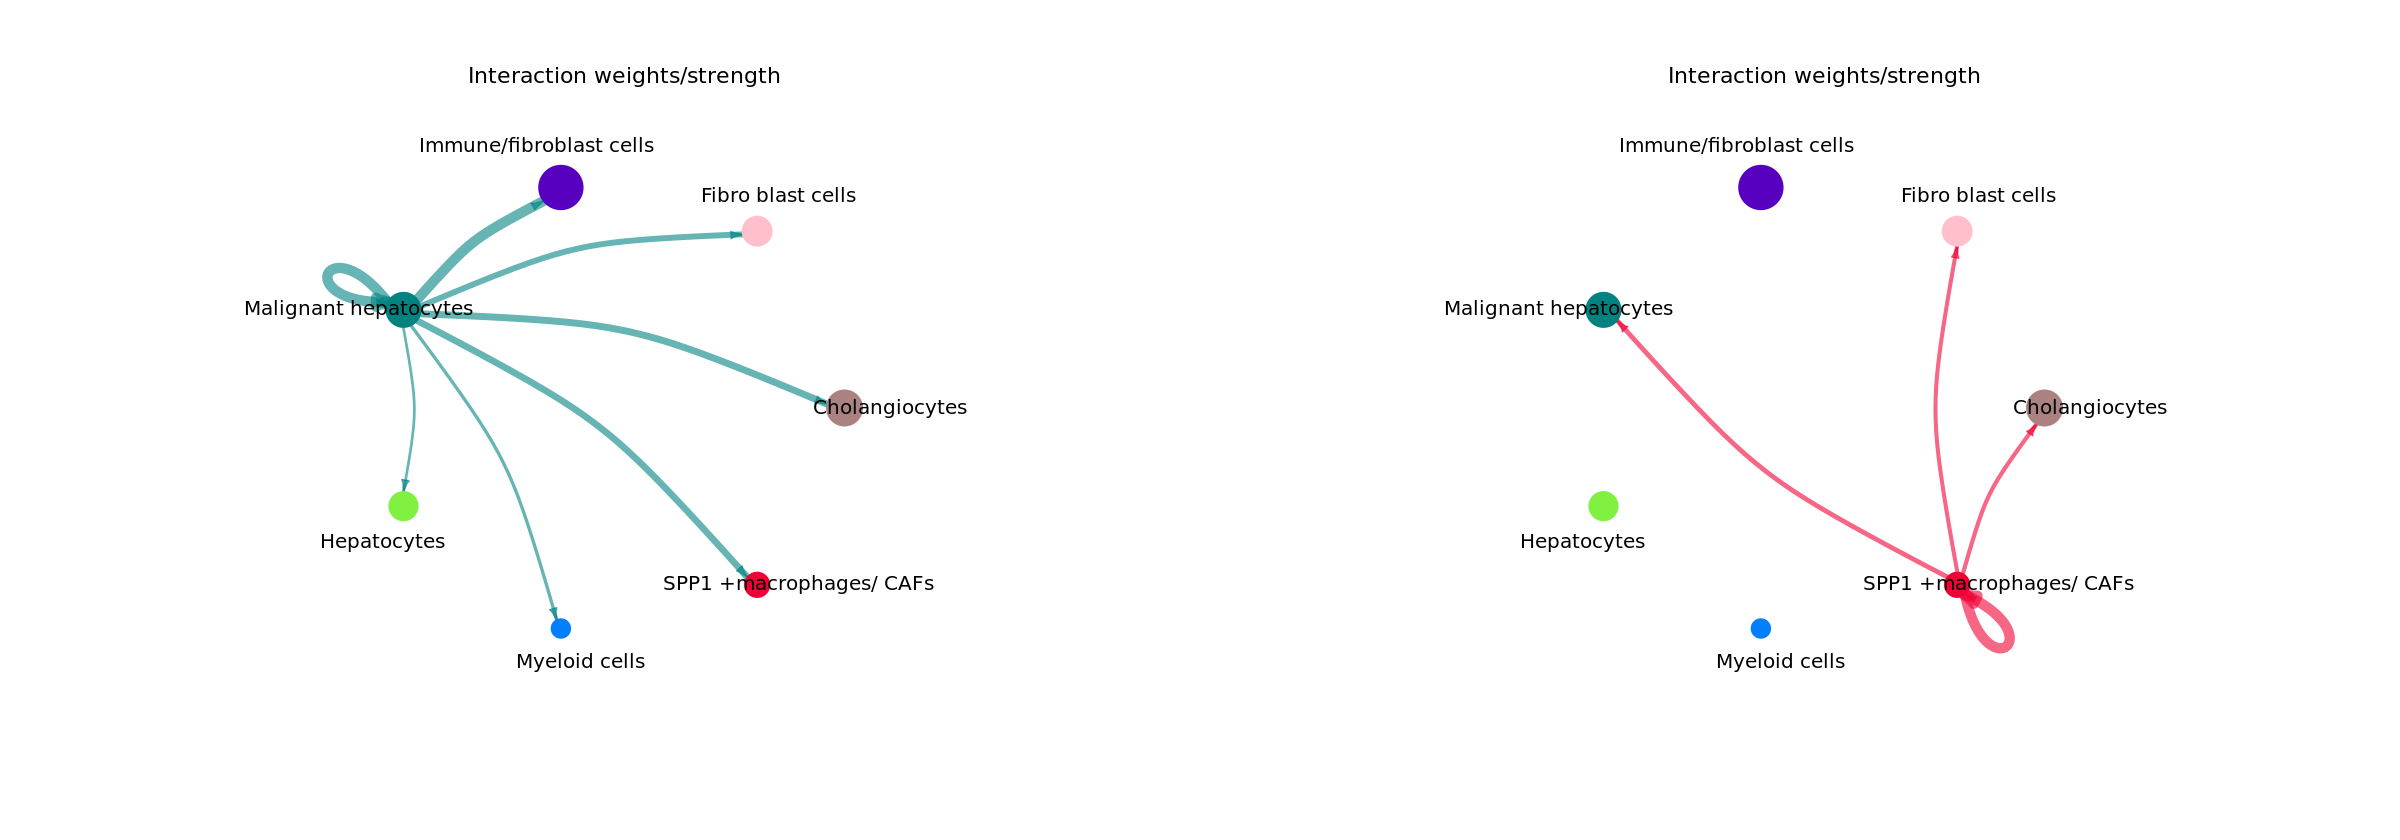

In [45]:
par(mfrow = c(1,2), xpd=T)
netVisual_circle(cellchat_p9T@net$weight, vertex.weight = rowSums(cellchat_p9T@net$weight), weight.scale = T, label.edge= F, title.name = "Interaction weights/strength", 
                 sources.use = "Malignant hepatocytes", color.use = c("#AA8282",
                                                                     "#FFC0CB", 
                                                                     "#5800C0FF", "#008281FF", "#80F041FF",
                                                                     "#007FFF", "#F00034FF"))
netVisual_circle(cellchat_p9T@net$weight, vertex.weight = rowSums(cellchat_p9T@net$weight), weight.scale = T, label.edge= F, title.name = "Interaction weights/strength", 
                 sources.use = "SPP1 +macrophages/ CAFs", color.use = c("#AA8282",
                                                                     "#FFC0CB", 
                                                                     "#5800C0FF", "#008281FF", "#80F041FF",
                                                                     "#007FFF", "#F00034FF"))

# Fig5C,D

In [17]:
pal_exp <- c("#450597", "#91169C", "#CA497A",
             "#EF8550", "#F8D02F", "#F0F921")
prismatic::color(pal_exp)

<colors>
#450597FF #91169CFF #CA497AFF #EF8550FF #F8D02FFF #F0F921FF 

## 5C

Extract coordinate info:

In [11]:
metadata_ds <- data.frame(spa_p1T@meta.data)
metadata_ds$cell_types_interest <- as.character(spa_p1T@active.ident)
# colnames(metadata_ds) <- colnames(cortex_sp@meta.data)
# cell_types_interest <- cell_types_all

spatial_coord_p1T_plot <- data.frame(spa_p1T@images[[2]]@coordinates) %>%
        tibble::rownames_to_column("barcodeID") %>% dplyr::mutate(imagerow_scaled = imagerow *
        spa_p1T@images[[2]]@scale.factors$lowres, imagecol_scaled = imagecol *
        spa_p1T@images[[2]]@scale.factors$lowres) %>% dplyr::inner_join(metadata_ds %>%
        tibble::rownames_to_column("barcodeID"), by = "barcodeID")

Gene exp:

In [19]:
spatial_coord_p1T_plot$CD3D <- FetchData(spa_p1T, vars = "CD3D")[,1]
spatial_coord_p1T_plot$CD8A <- FetchData(spa_p1T, vars = "CD8A")[,1]
spatial_coord_p1T_plot$GZMA <- FetchData(spa_p1T, vars = "GZMA")[,1]

basic visualization:

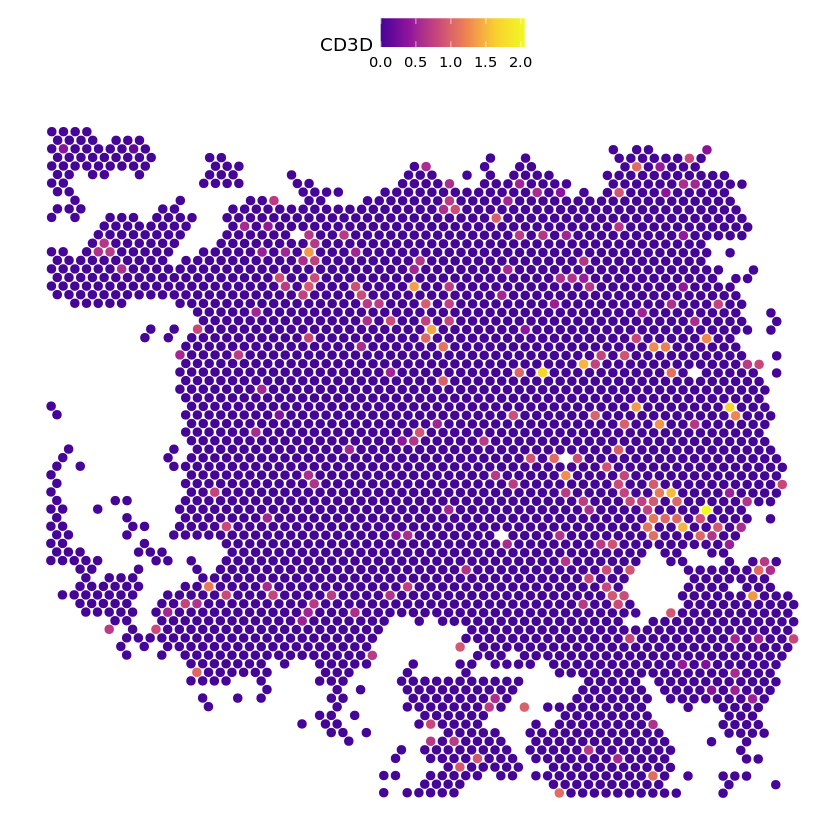

In [20]:
ggplot() + geom_point(data = spatial_coord_p1T_plot, aes(x = imagecol_scaled,y = imagerow_scaled,color = CD3D), size = 2) + scale_y_reverse() + theme_classic() + theme(
  axis.text = element_blank(),
  axis.title = element_blank(),
  axis.line = element_blank(),
  axis.ticks = element_blank(),
  legend.position = "top"
) + scale_color_gradientn(colours = pal_exp)

Slight optimization:

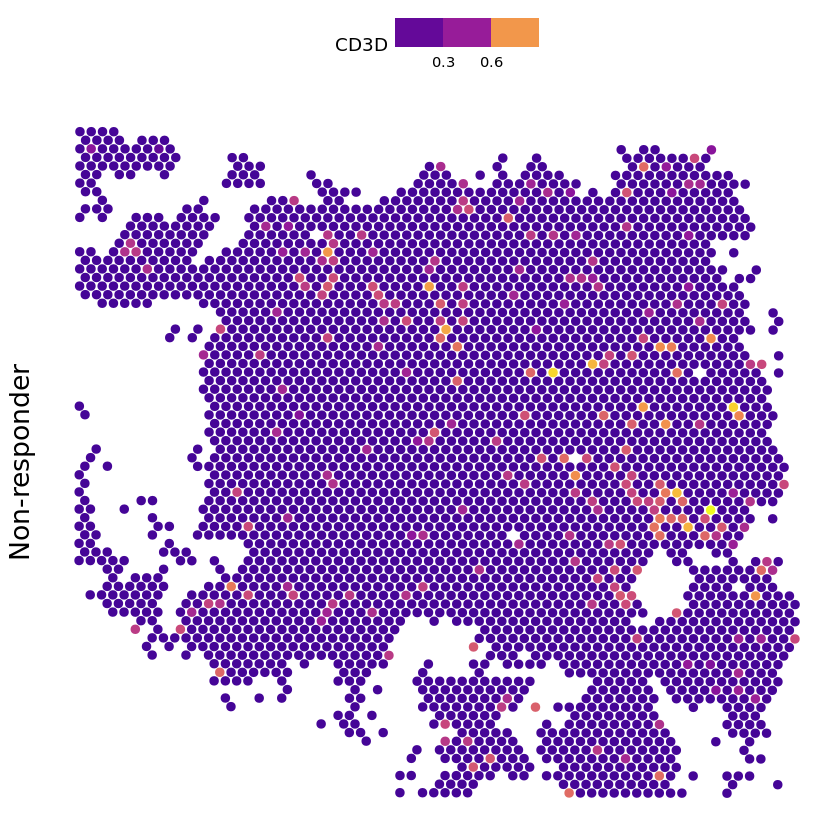

In [25]:
pc_1 <- ggplot() + geom_point(data = spatial_coord_p1T_plot, aes(x = imagecol,y = imagerow,color = CD3D), size = 2) + scale_y_reverse() + theme_classic() + theme(
    axis.text = element_blank(), axis.title.y = element_text(size = 16),
    axis.title.x = element_blank(),
    axis.line = element_blank(),
    axis.ticks = element_blank(),
    legend.position = "top"
) + scale_color_gradientn(
  colours = pal_exp,
  breaks = c(0.3, 0.6),
  guide = guide_coloursteps(even.steps = T)
                          ) + labs(y = "Non-responder")
pc_1

Patchwork

In [32]:
pc_2 <- ggplot() + geom_point(data = spatial_coord_p1T_plot, aes(x = imagecol,y = imagerow,color = CD8A), size = 2) + scale_y_reverse() + theme_classic() + theme(
    axis.text = element_blank(),
    axis.title = element_blank(),
    axis.line = element_blank(),
    axis.ticks = element_blank(),
    legend.position = "top"
) + scale_color_gradientn(
  colours = pal_exp,
  breaks = c(0.3, 0.6),
  guide = guide_coloursteps(even.steps = T)
                          )
pc_3 <- ggplot() + geom_point(data = spatial_coord_p1T_plot, aes(x = imagecol,y = imagerow,color = GZMA), size = 2) + scale_y_reverse() + theme_classic() + theme(
    axis.text = element_blank(),
    axis.title = element_blank(),
    axis.line = element_blank(),
    axis.ticks = element_blank(),
    legend.position = "top"
) + scale_color_gradientn(
  colours = pal_exp,
  breaks = c(0.2, 0.4),
  guide = guide_coloursteps(even.steps = T)
                          )

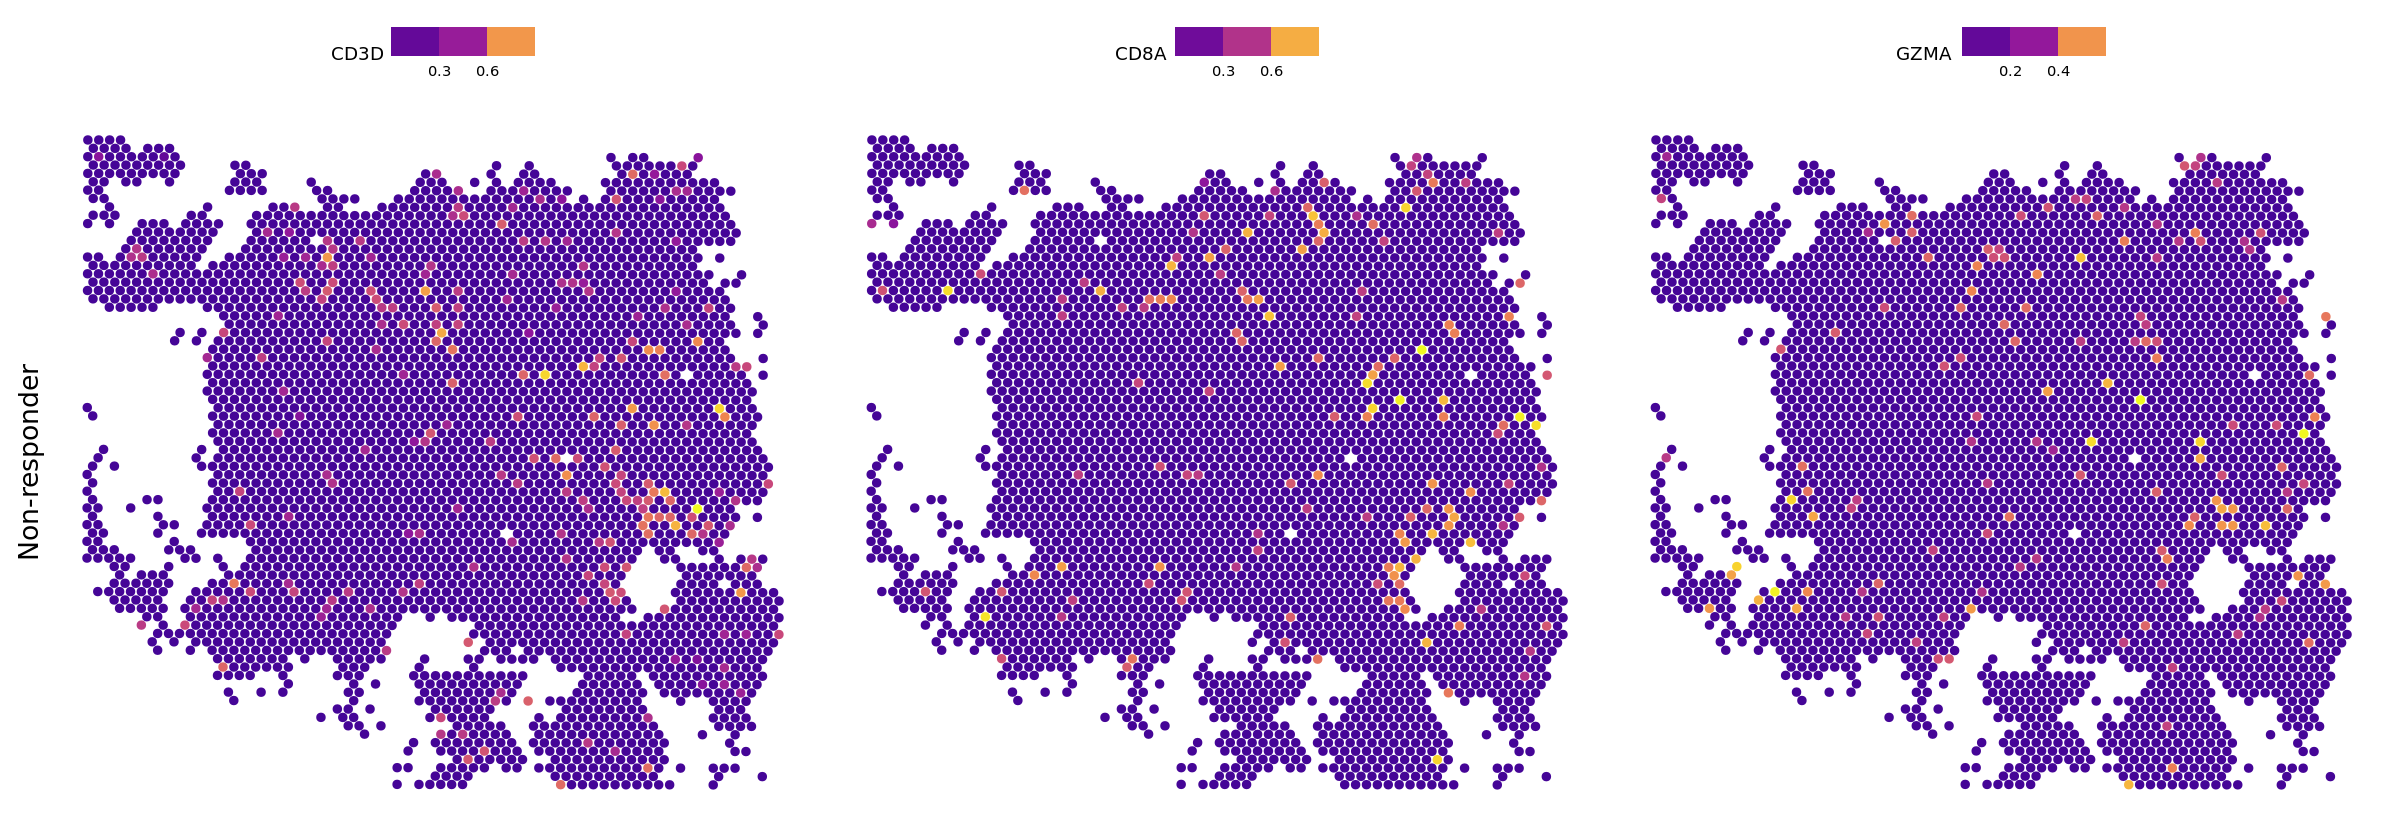

In [33]:
options(repr.plot.width=20)
pc <- pc_1 + pc_2 + pc_3
pc

## 5D

Same as fig5c.

In [31]:
metadata_ds <- data.frame(spa_p9T@meta.data)
metadata_ds$cell_types_interest <- as.character(spa_p9T@active.ident)

spatial_coord_p9T_plot <- data.frame(spa_p9T@images$image@coordinates) %>%
        tibble::rownames_to_column("barcodeID") %>% dplyr::mutate(imagerow_scaled = imagerow *
        spa_p9T@images$image@scale.factors$lowres, imagecol_scaled = imagecol *
        spa_p9T@images$image@scale.factors$lowres) %>% dplyr::inner_join(metadata_ds %>%
        tibble::rownames_to_column("barcodeID"), by = "barcodeID")

spatial_coord_p9T_plot$CD3D <- FetchData(spa_p9T, vars = "CD3D")[,1]
spatial_coord_p9T_plot$CD8A <- FetchData(spa_p9T, vars = "CD8A")[,1]
spatial_coord_p9T_plot$GZMA <- FetchData(spa_p9T, vars = "GZMA")[,1]

In [36]:
pd_1 <- ggplot() + geom_point(data = spatial_coord_p9T_plot, aes(x = imagecol,y = imagerow,color = CD8A), size = 2) + scale_y_reverse() + theme_classic() + theme(
    axis.text = element_blank(), 
    axis.title.x = element_blank(), axis.title.y = element_text(size = 16),
    axis.line = element_blank(),
    axis.ticks = element_blank(),
    legend.position = "top"
) + scale_color_gradientn(
  colours = pal_exp,
  breaks = c(1, 2, 3),
  guide = guide_coloursteps(even.steps = T)
                          ) + labs(y = "Responder")
pd_2 <- ggplot() + geom_point(data = spatial_coord_p9T_plot, aes(x = imagecol,y = imagerow,color = CD8A), size = 2) + scale_y_reverse() + theme_classic() + theme(
    axis.text = element_blank(),
    axis.title = element_blank(),
    axis.line = element_blank(),
    axis.ticks = element_blank(),
    legend.position = "top"
) + scale_color_gradientn(
  colours = pal_exp,
  breaks = c(0.5, 1.0, 1.5),
  guide = guide_coloursteps(even.steps = T)
                          )
pd_3 <- ggplot() + geom_point(data = spatial_coord_p9T_plot, aes(x = imagecol,y = imagerow,color = GZMA), size = 2) + scale_y_reverse() + theme_classic() + theme(
    axis.text = element_blank(),
    axis.title = element_blank(),
    axis.line = element_blank(),
    axis.ticks = element_blank(),
    legend.position = "top"
) + scale_color_gradientn(
  colours = pal_exp,
  breaks = c(0.5, 1.5, 2.5),
  guide = guide_coloursteps(even.steps = T)
                          )

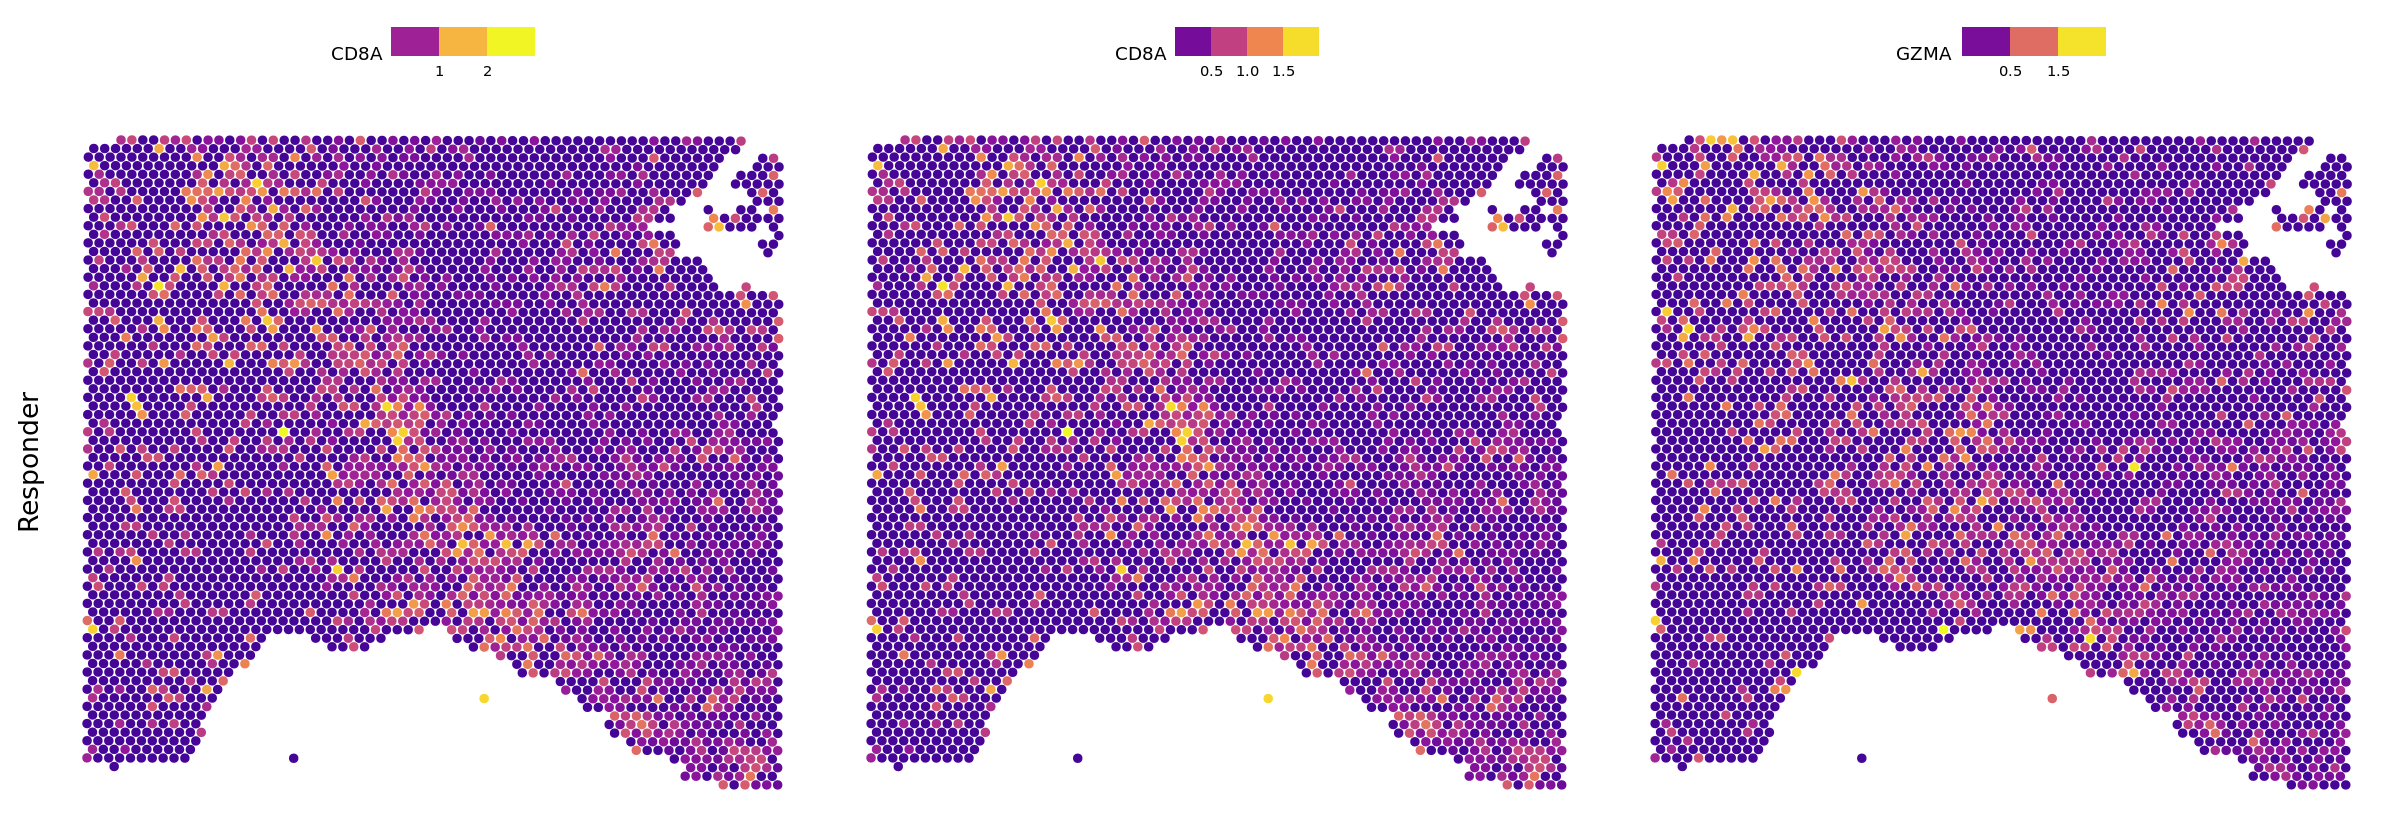

In [37]:
options(repr.plot.width=20)
pd <- pd_1 + pd_2 + pd_3
pd

# Fig5E,F

## Preprocess

In [54]:
myeloid_suppressive <- c("CD274", "IDO1", "LILRB4", "LILRB2", "TGFB1", "TNFRSF18", "LGALS9", "TNFRSF14", "TDO2")
GEP <- c("CCL5", "CD27", "CD274", "CD276", "CD8A", "CMKLR1", "CXCL9", "CXCR6", "HLA-DQA1", "HLA-DRB1", "HLA-E", "IDO1", "LAG3", "NKG7", "PDCD1LG2", "PSMB10", "STAT1", "TIGIT")

# Biocarta db
# author dont provide
ECM <- GSEABase::getGmt("tos_data/Data/fig5/BIOCARTA_ECM_PATHWAY.v2023.2.Hs.gmt")
ECM <- ECM@.Data[[1]]@geneIds

In [58]:
add_score_list <- list(
  myeloid_suppressive = myeloid_suppressive,
  GEP = GEP,
  ECM = ECM
)
spa_p1T <- AddModuleScore(
  object = spa_p1T,
  features = add_score_list,
  ctrl = 5,
  names = c("myeloid_suppressive", "GEP", "ECM")
)
colnames(spa_p1T@meta.data)[10:12] <- names(add_score_list)
colnames(spa_p1T@meta.data)

[1] "orig.ident"          "nCount_Spatial"      "nFeature_Spatial"   
 [4] "Tissues"             "Pat_Tissues"         "Mito.percent"       
 [7] "DefineTypes"         "SPP1_Macrophage"     "CAF"                
[10] "myeloid_suppressive" "GEP"                 "ECM"

In [62]:
pal <- c("#F00034", "#5800C0", "#FFBC00",
         "#80F041", "#008281", "#139AB6", "#23504F")
prismatic::color(pal)

<colors>
#F00034FF #5800C0FF #FFBC00FF #80F041FF #008281FF #139AB6FF #23504FFF 

## 5E

In [59]:
spa_p1T$DefineTypes2 <- factor(spa_p1T$DefineTypes,
                                levels = c("SPP1_Macrophage/CAF", "Immune_Fibroblast", "Myofibroblast_Pericyte", "hepatocyte", "malignant hepatocyte", "HMGB2 malignant hepatocyte", "MAP3K12 malignant hepatocyte"))

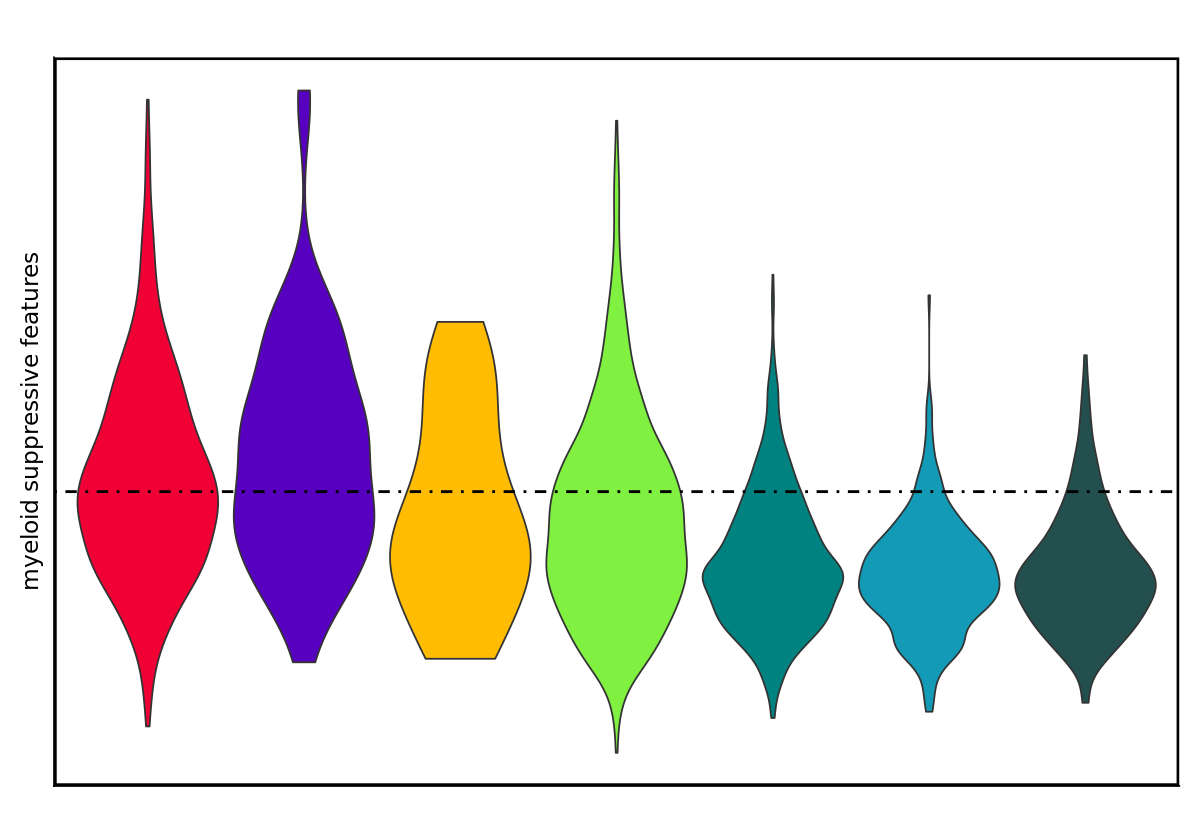

In [64]:
options(repr.plot.width=10)
pe_1 <- VlnPlot(spa_p1T, features = "myeloid_suppressive", pt.size = 0, group.by = "DefineTypes2") + theme(legend.position = "None") + geom_hline(yintercept = median(spa_p1T@meta.data$myeloid_suppressive[spa_p1T@meta.data$DefineTypes2 %in% "SPP1_Macrophage/CAF"]), lty=4,col="black",lwd=0.8) + 
  scale_fill_manual(values = pal) + labs(y = "myeloid suppressive features",
                                         x = "") + ggtitle("") + theme(
                                          axis.text.y = element_blank(),
                                          axis.ticks.y = element_blank(),
                                          axis.ticks = element_blank(),
                                          axis.text.x = element_blank(),
                                          panel.border = element_rect(color = "black", linewidth = 1.5, fill = NA)
                                         )
pe_1

In [69]:
pe_2 <- VlnPlot(spa_p1T, features = "ECM", pt.size = 0, group.by = "DefineTypes2") + theme(legend.position = "None") + geom_hline(yintercept = median(spa_p1T@meta.data$ECM[spa_p1T@meta.data$DefineTypes2 %in% "SPP1_Macrophage/CAF"]), lty=4,col="black",lwd=0.8) + 
  scale_fill_manual(values = pal) + labs(y = "ECM features",
                                         x = "") + ggtitle("") + theme(
                                          axis.text.y = element_blank(),
                                          axis.ticks.y = element_blank(),
                                          axis.text.x = element_text(size = 15),
                                          axis.ticks = element_blank(),
                                        #  axis.text.x = element_blank(),
                                          panel.border = element_rect(color = "black", linewidth = 1.5, fill = NA)
                                         )

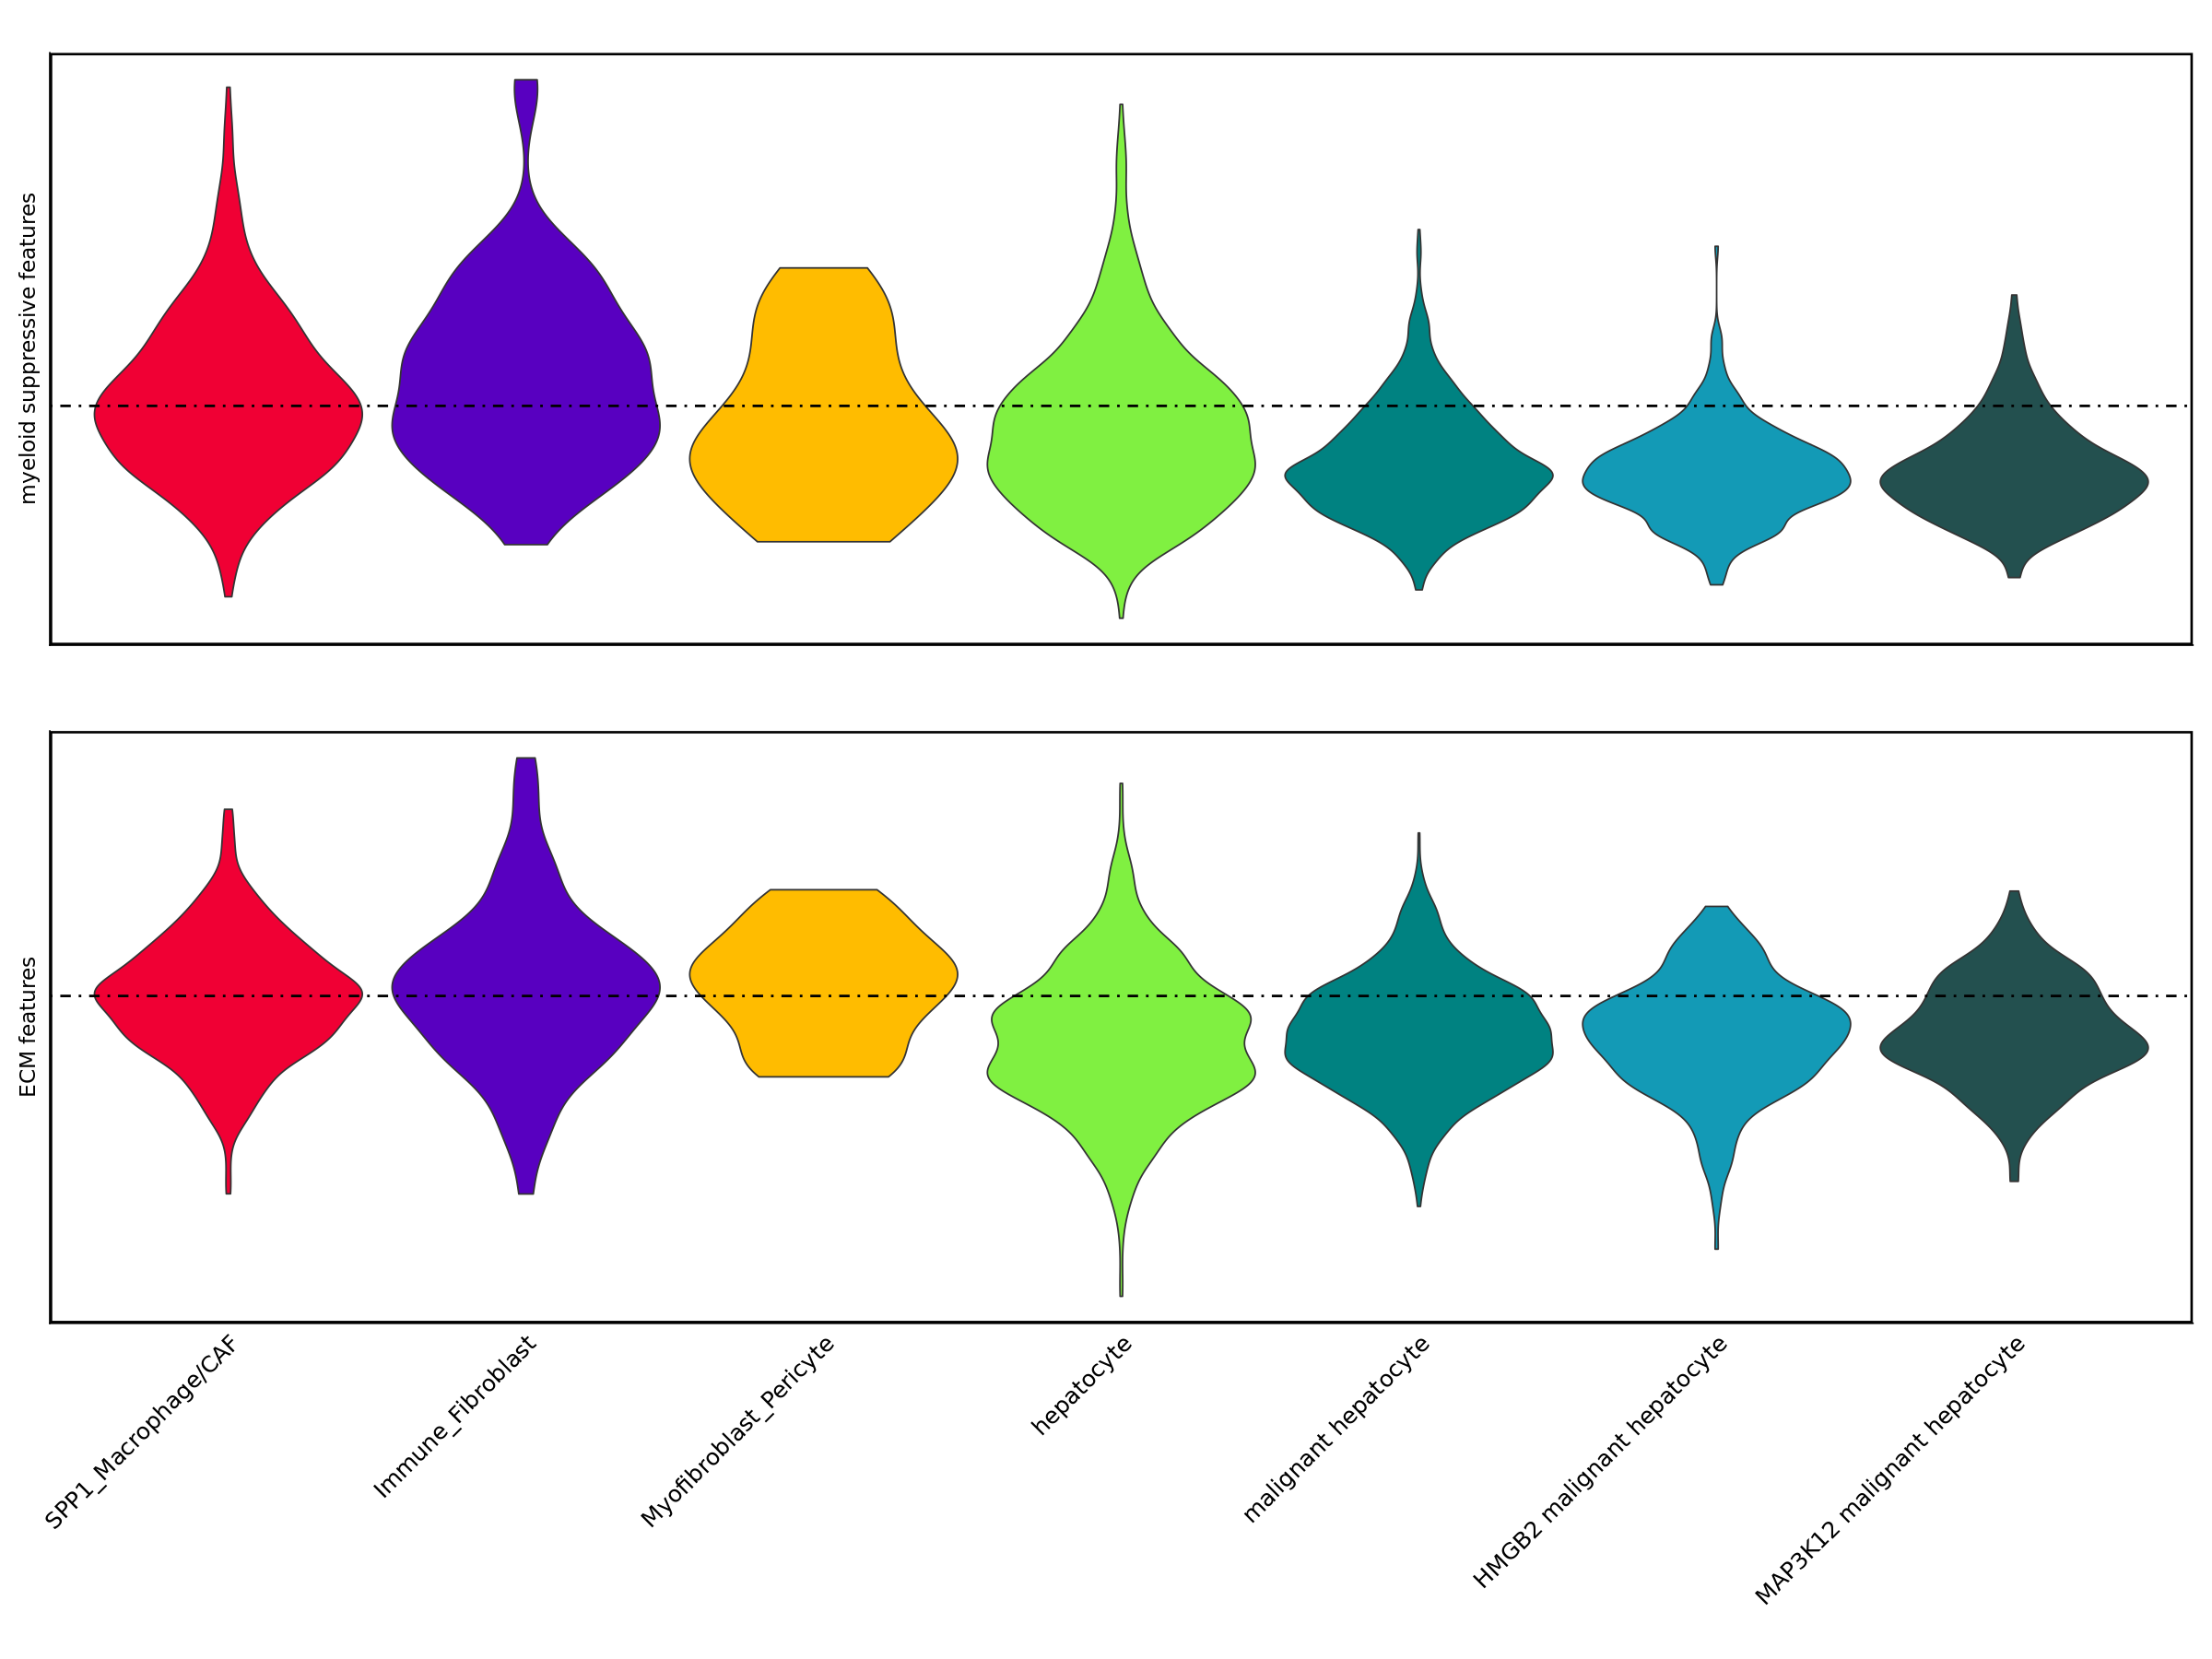

In [70]:
options(repr.plot.width=20,repr.plot.height=15)
pe <- pe_1/pe_2
pe

## 5F

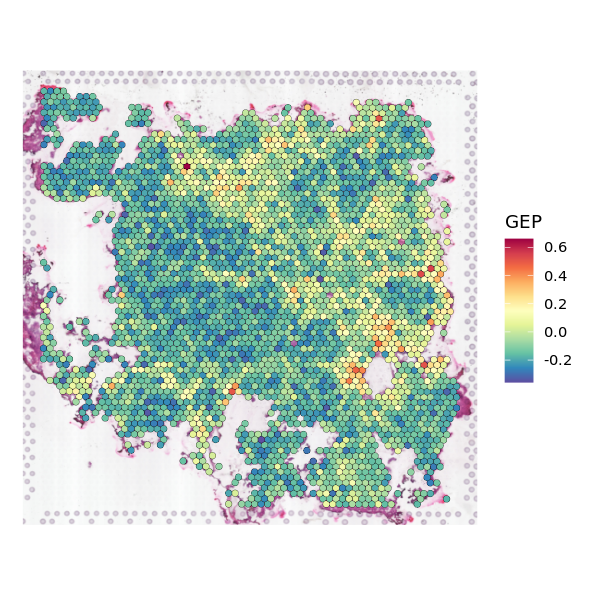

In [73]:
options(repr.plot.width=5,repr.plot.height=5)
SpatialFeaturePlot(spa_p1T, images = "image_P11_T", features = "GEP") + theme(legend.position = "right")


adjust result:

In [74]:
spa_p1T$GEP.score <- (spa_p1T$GEP-min(spa_p1T$GEP))/(max(spa_p1T$GEP)-min(spa_p1T$GEP))

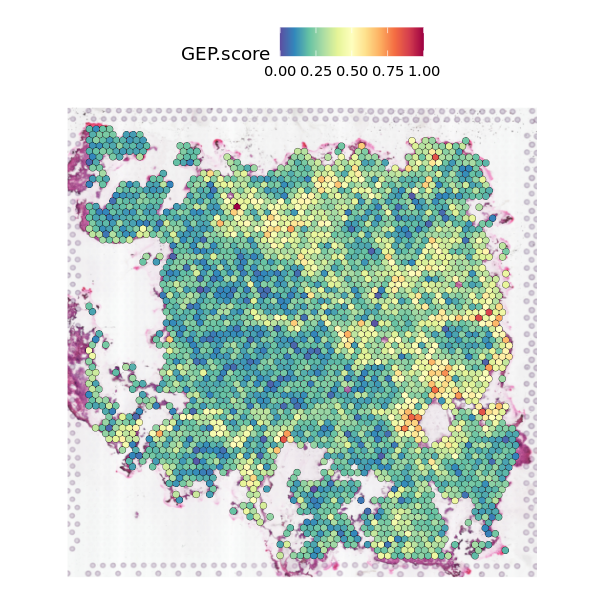

In [77]:
pf <- SpatialFeaturePlot(spa_p1T, images = "image_P11_T", features = "GEP.score") + theme(legend.position = "top")
pf

# Fig5G

Calculate pseudo exp

In [78]:
pseudo_exp <- AggregateExpression(spa_p1T, assays = "Spatial", return.seurat = F, group.by = c("DefineTypes"))
pseudo_exp <- pseudo_exp$Spatial
pseudo_exp <- as.matrix(pseudo_exp)
colnames(pseudo_exp) <- unname(colnames(pseudo_exp))
pseudo_exp <- pseudo_exp[,match(levels(spa_p1T$DefineTypes2), colnames(pseudo_exp))]

Prepare pheatmap input:

In [80]:
color_brew <- rev(c('#b2182b','#d6604d','#f4a582','#fddbc7','#d1e5f0','#92c5de','#4393c3','#2166ac','#053061'))
prismatic::color(color_brew)

<colors>
#053061FF #2166ACFF #4393C3FF #92C5DEFF #D1E5F0FF #FDDBC7FF #F4A582FF #D6604DFF #B2182BFF 

In [81]:
annotation_col <- data.frame(
  type = colnames(pseudo_exp)
)
rownames(annotation_col) <- colnames(pseudo_exp)

pseudo_exp2 <- pseudo_exp[rownames(pseudo_exp) %in% GEP,]
pseudo_exp2 <- pseudo_exp2[match(GEP,rownames(pseudo_exp2)),]
color_brew <- rev(c('#b2182b','#d6604d','#f4a582','#fddbc7','#d1e5f0','#92c5de','#4393c3','#2166ac','#053061'))
pal2 <- pal
names(pal2) <- annotation_col$type
ann_colors = list(
  type = pal2
)

In [84]:
head(pseudo_exp2)

SPP1_Macrophage/CAF Immune_Fibroblast Myofibroblast_Pericyte hepatocyte
CCL5   207.24007           113.4339770        8.6614502             203.79029 
CD27    78.47953            42.2851936        1.1835874              68.43605 
CD274   14.38946             0.9237022        1.2471938              11.52674 
CD276  192.44290            27.3488249       11.4132426             288.32507 
CD8A    49.40002            17.7508009        0.5155171              57.31229 
CMKLR1 103.78842            13.0805137        0.9251978              83.79098 
       malignant hepatocyte HMGB2 malignant hepatocyte
CCL5   131.37488             18.708456                
CD27    53.16343             10.864892                
CD274   12.76358              2.639249                
CD276  545.63577            117.316857                
CD8A    30.42053              9.848937                
CMKLR1  86.77285              7.839648                
       MAP3K12 malignant hepatocyte
CCL5   22.5226113                  
CD27    7.8980483                  
CD274   0.0000000                  
CD276  81.1596901                  
CD8A    0.7123522                  
CMKLR1  8.5008308

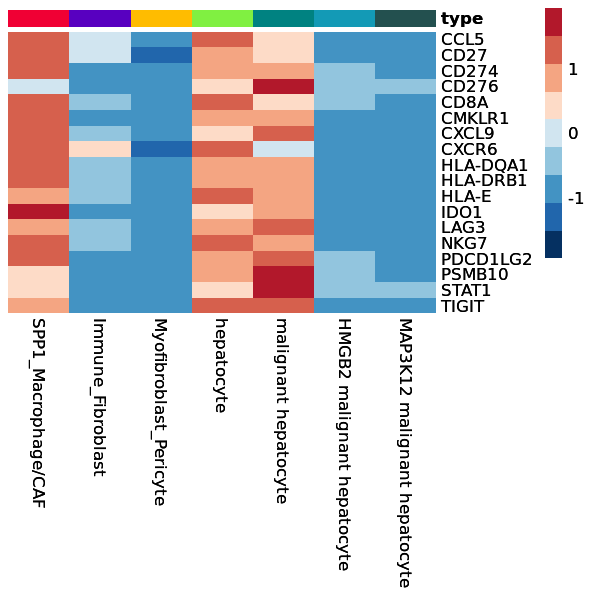

In [82]:
pg <- pheatmap::pheatmap(pseudo_exp2, scale = "row", cluster_cols = F, cluster_rows = F, annotation_col = annotation_col, color = color_brew, annotation_colors = ann_colors, 
                   border_color = "NA", annotation_legend = F)
pg

# Save